In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Load the dataset
transcript_df = pd.read_csv("transcript.csv")

# Display the first few rows of the dataframe
print(transcript_df.head())


   start                                     text
0   0.04     today the goal is not to do well the
1   3.08  goal is to make as many mistakes as you
2   5.08     can here in a safe environment often
3  7.359   times when I do these trainings people
4   8.76   are embarrassed when there's 50 people


In [6]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3645 entries, 0 to 3644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   3644 non-null   float64
 1   text    3645 non-null   object 
dtypes: float64(1), object(1)
memory usage: 57.1+ KB
None

Basic Statistics:
             start
count  3644.000000
mean   4632.572405
std    2689.182168
min       0.040000
25%    2314.130000
50%    4672.480000
75%    7007.440000
max    9286.520000


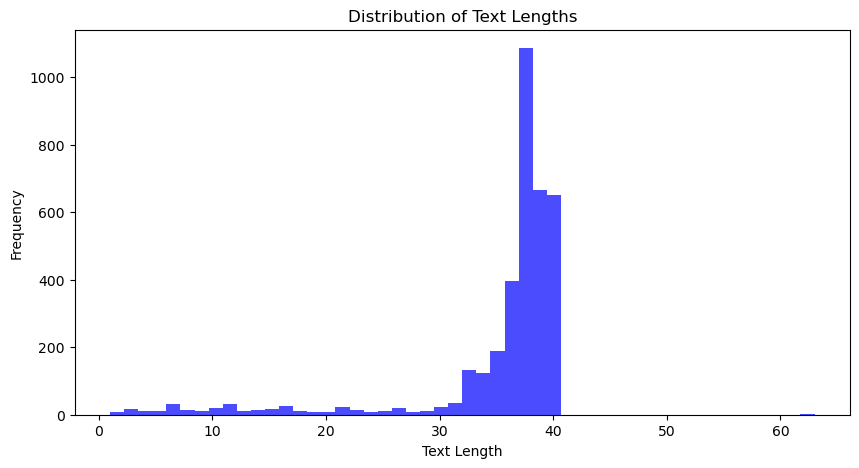

In [7]:
# distribution of text lengths
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

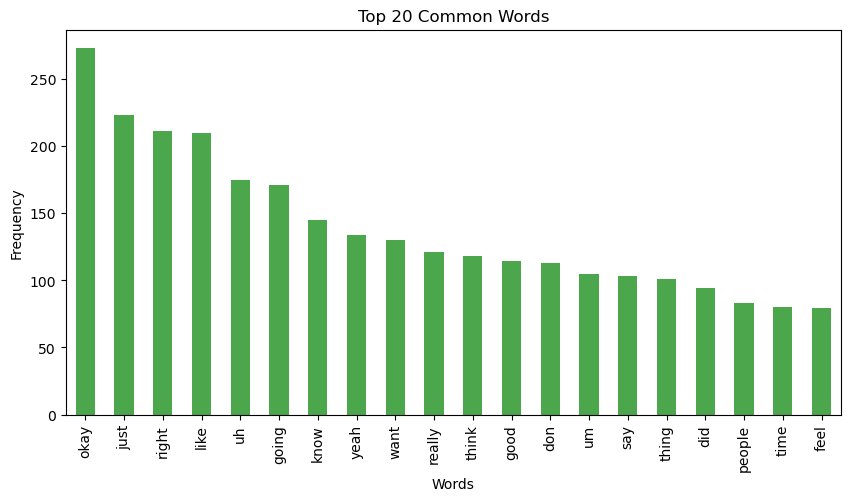

In [8]:
# most common words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [9]:
# topic Modeling using NMF
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: okay let pause thank try ll david stop rebecca hand
Topic 2: like feel did lot didn time day hand oh felt
Topic 3: just say tell talk let ll start try body things
Topic 4: right thing away ll yes time focus say make round
Topic 5: uh um great body david story movement started engaged did
Topic 6: going say ask talk people question try let speech yes
Topic 7: know don say let talk talking way didn mind people
Topic 8: good really um think thing did story don great people
Topic 9: yeah did story thank point time say oh yes great
Topic 10: want time don message speaking problem tell try say people


In [10]:
# get topic distribution for each text segment
topic_distribution = nmf.transform(tf)

# align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [11]:
# analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [12]:
# consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [13]:
# merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

In [14]:


for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # append the last chapter

In [15]:
# Convert the final chapters to a readable time format
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:03 - Chapter 1: good really think
00:01:05 - Chapter 2: just okay tell
00:02:06 - Chapter 3: going say talk
00:03:08 - Chapter 4: good really think
00:04:09 - Chapter 5: problem time want
00:05:09 - Chapter 6: body like uh
00:06:10 - Chapter 7: speaking time want
00:07:11 - Chapter 8: applause let okay
00:08:12 - Chapter 9: going say talk
00:10:19 - Chapter 10: good really think
00:11:25 - Chapter 11: did story yeah
00:12:28 - Chapter 12: applause let okay
00:14:36 - Chapter 13: did story yeah
00:15:37 - Chapter 14: going say talk
00:16:44 - Chapter 15: body uh um
00:17:45 - Chapter 16: good really think
00:18:45 - Chapter 17: did story yeah
00:20:48 - Chapter 18: day feel like
00:21:49 - Chapter 19: don know stress
00:22:51 - Chapter 20: focus ll right
00:23:58 - Chapter 21: good really think
00:26:02 - Chapter 22: applause let okay
00:27:03 - Chapter 23: brain don know
00:28:04 - Chapter 24: speaking time want
00:29:05 - Chapter 25: did story y